<a href="https://colab.research.google.com/github/sgu20191619/DACON/blob/main/LGAImers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [307]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [308]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [309]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import sklearn

from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import Perceptron
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

In [310]:
def print_statistics(df, col):

  max = df[col].max()
  min = df[col].min()
  mean = df[col].mean()
  median = df[col].median()

  print(f'{col}의 최대값 : {max}')
  print(f'{col}의 최소값 : {min}')
  print(f'{col}의 평균값 : {mean}')
  print(f'{col}의 중앙값 : {median}')

In [311]:
def value_hist(df, col, target='Y_Quality'):

  for value in df[col].unique():

    cond = (df[col]==value)
    cond_df = df.loc[cond]

    print(f'{value} 데이터 갯수 : {cond_df.shape[0]}')
    print_statistics(cond_df, target)

    fig, ax = plt.subplots(ncols=2, figsize=(13, 6))

    sns.histplot(data=cond_df, x='Y_Quality', ax=ax[0])
    ax[0].set_title(f'{col} {value}')
    ax[0].set_xticks(range(0,int(df[target].max()+1)), 20)

    sns.boxplot(data=cond_df, x='Y_Quality', ax=ax[1])
    ax[1].set_title(f'{col} {value} Box Plot')
    
    plt.show()

In [312]:
def value_hist2(df, col, target='Y_Class'):

  for value in df[col].unique():

    cond = (df[col]==value)
    cond_df = df.loc[cond]

    print(f'{value} 데이터 갯수 : {cond_df.shape[0]}')
    print_statistics(cond_df, target)

    fig, ax = plt.subplots(ncols=2, figsize=(13, 6))

    sns.histplot(data=cond_df, x='Y_Class', ax=ax[0])
    ax[0].set_title(f'{col} {value}')
    ax[0].set_xticks(range(0,int(df[target].max()+1)), 20)

    sns.boxplot(data=cond_df, x='Y_Class', ax=ax[1])
    ax[1].set_title(f'{col} {value} Box Plot')
    
    plt.show()
    return cond_df[target].mean()

In [313]:
def remove_outliers(df, threshold):
    # Calculate the first and third quartiles for every column
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)

    # Calculate the interquartile range (IQR) for every column
    iqr = q3 - q1

    # Define the lower and upper bounds for identifying outliers for every column
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr

    # Replace outliers for every column with the median value of the column
    df_clean = df.copy()
    for col in df.columns:
      if col == "Y_Class" or col == "Y_Quality" :
        continue
      outliers_mask = (df_clean[col] < lower_bound[col]) | (df_clean[col] > upper_bound[col])
      df_clean.loc[outliers_mask, col] = df_clean[col].median()

    return df_clean


In [314]:
import random
import os
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) # Seed 고정

In [315]:
train_df = pd.read_csv("/content/drive/MyDrive/LGAimers/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/LGAimers/test.csv")

In [316]:
train_df = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])
test_df = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])

from sklearn.preprocessing import LabelEncoder

qual_col = ['LINE', 'PRODUCT_CODE']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train_df[i])
    train_df[i] = le.transform(train_df[i])
    
    for label in np.unique(test_df[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_df[i] = le.transform(test_df[i]) 
print('Done.')

Done.


In [317]:
# 전처리 
# LINE CLASS CODE 별로 나누어 결측치 대체 
train_class = []
for i in range(3) :
  train_class.append(train_df.loc[train_df["Y_Class"].isin([i])])

line = train_df["LINE"].unique()
train_class_line = []
for df in train_class :
  for l in line :
    train_class_line.append(df.loc[df["LINE"].isin([l])])

code = train_df["PRODUCT_CODE"].unique()
train_class_line_code = [] 
for df in train_class_line :
  for c in code :
    train_class_line_code.append(df.loc[df["PRODUCT_CODE"].isin([c])])

for i in range(len(train_class_line_code)) :
  train_class_line_code[i] = train_class_line_code[i].fillna((train_class_line_code[i].mode() + train_class_line_code[i].mean()) / 2 )
  train_class_line_code[i] =  train_class_line_code[i].fillna(0)

In [318]:
train = pd.concat(train_class_line_code)
train = train.reset_index(drop = True)

y_class = train["Y_Class"]
y_quality = train["Y_Quality"]

train = train.drop(columns=['Y_Class', 'Y_Quality'])
X = train 

In [319]:
from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# X = scaler.fit_transform(train)
# X = pd.DataFrame(X, columns = train.columns)

In [ ]:
correlations = []
for feature in X.columns:
  correlation, _ = pearsonr(X[feature], y_class)
  correlations.append(correlation)

correlations2 = []
for feature in X.columns:
    correlation, _ = pearsonr(X[feature], y_quality)
    correlations2.append(correlation)

k = len(X.columns) // 2 
top_k_indices = sorted(range(len(correlations)), key=lambda i: abs(correlations[i]), reverse=True)[:k]
top_k_features = X.columns[top_k_indices]

top_k_indices = sorted(range(len(correlations2)), key=lambda i: abs(correlations2[i]), reverse=True)[:k]
top_k_features2 = X.columns[top_k_indices]

features = list(top_k_features) + list(top_k_features2)

final_features = list(set(features))

X = X[final_features]
X.head()

In [ ]:
# 값이 하나라면 과감하게 column을 drop함
const_cols = X.columns[X.nunique() == 1] 
X = X.drop(const_cols, axis=1)

print(const_cols)

In [322]:
# from sklearn.linear_model import Lasso

# scaler = StandardScaler()
# X_std = scaler.fit_transform(X)

# X_train, X_val, y_train, y_val = train_test_split(X_std, y_class, test_size=0.3, random_state=37)

# lasso = Lasso(alpha=0.1)
# lasso.fit(X_train, y_train)

# # print('Coefficients:', lasso.coef_)
# # print('Intercept:', lasso.intercept_)

# important_features = X.columns[abs(lasso.coef_) > 0]

# print('Important features:', important_features)

# X = X[important_features]

In [ ]:
# Validation set으로 여러 기본모델의 스코어 측정 

X_train, X_val, y_train, y_val = train_test_split(X, y_class, test_size = 0.2, random_state =37)

num = -1

xg_clf = xgb.XGBClassifier(
    # max_depth= 5,
    # eta= 0.001,
    # learning_rate= 0.001,
    # num_boost_round= 10000,
    # #min_child_weight= 3,
    # subsample= 0.8,
    # #colsample_bytree= 0.8,
    # alpha = 0.5
  )
xg_clf.fit(X_train, y_train)

rf_clf = RandomForestClassifier(
    # n_estimators=6000, 
    random_state=37,
    # max_depth = 4
  )
rf_clf.fit(X_train, y_train)

gb_clf = GradientBoostingClassifier(
    random_state=37,
    # n_estimators = 1000, 
    # max_depth = 4, 
    # learning_rate = 0.05
)
gb_clf.fit(X_train, y_train)


dt_clf = DecisionTreeClassifier(random_state=37)
dt_clf.fit(X_train, y_train)

lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X_train, y_train)

print("\n")
y_pred = xg_clf.predict(X_val)
accuracy = f1_score(y_val, y_pred, average = 'macro') 
print("XG : ", accuracy, end= '\n')
if (accuracy > num) :
  model = xg_clf
  num = accuracy

y_pred = rf_clf.predict(X_val)
accuracy = f1_score(y_val, y_pred, average = 'macro') 
print("RF : ", accuracy, end= '\n')
if (accuracy > num) :
  model = rf_clf
  num = accuracy

y_pred = gb_clf.predict(X_val)
accuracy = f1_score(y_val, y_pred, average = 'macro') 
print("GB : ", accuracy, end= '\n')
if (accuracy > num) :
  model = gb_clf
  num = accuracy

y_pred = dt_clf.predict(X_val)
accuracy = f1_score(y_val, y_pred, average = 'macro')  
print("DT : ", accuracy, end= '\n')
if (accuracy > num) :
  model = dt_clf
  num = accuracy

y_pred = lda_clf.predict(X_val)
accuracy = f1_score(y_val, y_pred, average = 'macro') 
print("LDA : ", accuracy, end= '\n')
if (accuracy > num) :
  model = lda_clf
  num = accuracy

In [324]:
model.fit(X, y_class)

importances = model.feature_importances_

feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})

feature_importances = feature_importances.sort_values('importance', ascending = False)

In [ ]:
feature_importances

In [326]:
arr = feature_importances['importance'][lambda x : x > 0 ]
cnt = len(arr)
cnt

601

In [327]:
final_X = X[feature_importances[:cnt]['feature']]

In [328]:
cnt = 0
for col in feature_importances[:cnt]['feature'] : 
  if (test_df[col].isnull().sum() == 310) :
    cnt += 1
print(cnt) 

0


In [ ]:
select_model = []

X_train, X_val, y_train, y_val = train_test_split(final_X, y_class, test_size = 0.2, random_state =37)

xg_clf = xgb.XGBClassifier(
    # max_depth= 4,
    # eta= 0.001,
    # learning_rate= 0.001,
    # num_boost_round= 6000,
    # min_child_weight= 3,
    # subsample= 0.7,
    # colsample_bytree= 0.7,
    # alpha = 0.5
)
xg_clf.fit(X_train, y_train)

rf_clf = RandomForestClassifier(n_estimators=1000, random_state=37)
rf_clf.fit(X_train, y_train)

# svm_clf = SVC(kernel='linear', random_state=42)
# svm_clf.fit(X_train, y_train)

knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)

lr_clf = LogisticRegression(random_state=37)
lr_clf.fit(X_train, y_train)

gb_clf = GradientBoostingClassifier(
    random_state=37,
    # n_estimators = 6000, 
    # max_depth = 4, 
    # learning_rate = 0.001, 
)
gb_clf.fit(X_train, y_train)

nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)

dt_clf = DecisionTreeClassifier(random_state=37)
dt_clf.fit(X_train, y_train)

perc_clf = Perceptron(random_state=37)
perc_clf.fit(X_train, y_train)

lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X_train, y_train)

mlp_clf = MLPClassifier(random_state=37)
mlp_clf.fit(X_train, y_train)

print("\n")
y_pred = xg_clf.predict(X_val)
accuracy = f1_score(y_val, y_pred, average = 'macro') 
print("XG : ", accuracy, end= '\n')
select_model.append((xg_clf,accuracy))

y_pred = rf_clf.predict(X_val)
accuracy = f1_score(y_val, y_pred, average = 'macro') 
print("RF : ", accuracy, end= '\n')
select_model.append((rf_clf,accuracy))

# y_pred = svm_clf.predict(X_val)
# accuracy = f1_score(y_val, y_pred, average = 'macro') 
# print("SVC : ", accuracy, end= '\n')

y_pred = knn_clf.predict(X_val)
accuracy = f1_score(y_val, y_pred, average = 'macro') 
print("KNN : ", accuracy, end= '\n')
select_model.append((knn_clf,accuracy))

y_pred = lr_clf.predict(X_val)
accuracy = f1_score(y_val, y_pred, average = 'macro') 
print("LR : ", accuracy, end= '\n')
select_model.append((lr_clf,accuracy))

y_pred = gb_clf.predict(X_val)
accuracy = f1_score(y_val, y_pred, average = 'macro') 
print("GB : ", accuracy, end= '\n')
select_model.append((gb_clf,accuracy))

y_pred = nb_clf.predict(X_val)
accuracy = f1_score(y_val, y_pred, average = 'macro') 
print("NB : ", accuracy, end= '\n')
select_model.append((nb_clf,accuracy))

y_pred = dt_clf.predict(X_val)
accuracy = f1_score(y_val, y_pred, average = 'macro')  
print("DT : ", accuracy, end= '\n')
select_model.append((dt_clf,accuracy))

y_pred = perc_clf.predict(X_val)
accuracy = f1_score(y_val, y_pred, average = 'macro')  
print("PERC : ", accuracy, end= '\n')
select_model.append((perc_clf,accuracy))

y_pred = lda_clf.predict(X_val)
accuracy = f1_score(y_val, y_pred, average = 'macro') 
print("LDA : ", accuracy, end= '\n')
select_model.append((lda_clf,accuracy))

y_pred = mlp_clf.predict(X_val)
accuracy = f1_score(y_val, y_pred, average = 'macro')  
print("MLP : ", accuracy, end= '\n')
select_model.append((mlp_clf,accuracy))


In [330]:
sorted_list = sorted(select_model, key = lambda x : x[1], reverse= True)
sorted_list

[(GradientBoostingClassifier(random_state=37), 0.7671221532091098),
 (RandomForestClassifier(n_estimators=1000, random_state=37),
  0.7405629458261037),
 (XGBClassifier(objective='multi:softprob'), 0.7018849071172276),
 (GaussianNB(), 0.5915412186379928),
 (LogisticRegression(random_state=37), 0.5866205918837498),
 (DecisionTreeClassifier(random_state=37), 0.5290699638525725),
 (KNeighborsClassifier(), 0.5093719502321653),
 (MLPClassifier(random_state=37), 0.509153648284083),
 (LinearDiscriminantAnalysis(), 0.46259539655766063),
 (Perceptron(random_state=37), 0.27257799671592775)]

In [331]:
X_train, X_val, y_train, y_val = train_test_split(final_X, y_class, test_size=0.2, random_state=37)

base_models = [
    GradientBoostingClassifier(random_state=37),
    RandomForestClassifier(n_estimators=1000, random_state=37),
    xgb.XGBClassifier(
      # max_depth= 4,
      # eta= 0.001,
      # learning_rate= 0.001,
      # num_boost_round= 8000,
      # min_child_weight= 3,
      # subsample= 0.8,
      # colsample_bytree= 0.8,
      # alpha = 0.5
    ),
]

# Define the meta model
meta_model = xgb.XGBClassifier(
    # max_depth= 4,
    # eta= 0.001,
    # learning_rate= 0.001,
    # num_boost_round= 10000,
    # min_child_weight= 3,
    # subsample= 0.7,
    # colsample_bytree= 0.7,
    # alpha = 0.5
)

# Define the number of folds for cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=37)

# Create an array to hold the out-of-fold predictions for each base model
X_train_meta = np.zeros((X_train.shape[0], len(base_models)))

# Train the base models and generate the out-of-fold predictions for the meta model
for i, model in enumerate(base_models):
    for train_idx, val_idx in kf.split(X_train):
        # Split the data into training and validation sets
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Train the model on the training set
        model.fit(X_train_fold, y_train_fold)

        # Generate predictions for the validation set
        y_val_pred = model.predict(X_val_fold)

        # Save the predictions for the validation set
        X_train_meta[val_idx, i] = y_val_pred

# Train the meta model on the out-of-fold predictions
meta_model.fit(X_train_meta, y_train)

# Generate the predictions for the test set
X_test_meta = np.zeros((X_val.shape[0], len(base_models)))
for i, model in enumerate(base_models):
    # Train the model on the full training set
    model.fit(X_train, y_train)

    # Generate predictions for the test set
    y_test_pred = model.predict(X_val)
    print(y_test_pred)
    # Save the predictions for the test set
    X_test_meta[:, i] = y_test_pred

# Generate the final predictions using the meta model
y_pred = meta_model.predict(X_test_meta)

# Evaluate the performance of the final predictions
accuracy = f1_score(y_val, y_pred, average='macro')
print("F1 score:", accuracy)

[1 2 2 1 1 1 0 1 1 2 1 0 1 1 1 1 1 2 1 2 1 1 0 1 1 2 1 1 0 1 1 1 1 1 0 1 1
 1 1 1 1 1 2 2 1 1 2 2 1 1 1 0 1 2 1 1 1 1 1 2 1 1 1 1 2 1 1 1 2 0 1 1 1 1
 1 1 1 2 2 1 1 1 0 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 0 1
 1 0 1 1 1 1 1 1 1]
[1 2 2 1 1 1 0 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1
 1 1 1 1 1 2 1 1 1 2 2 1 1 1 0 1 2 1 1 1 1 1 2 1 1 1 1 2 1 1 1 2 0 1 1 1 1
 1 1 1 1 2 1 1 1 0 1 1 1 1 2 1 1 1 1 0 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1]
[1 2 2 1 1 1 0 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 0 1 1
 1 1 1 1 1 2 1 1 1 2 2 1 1 1 0 1 2 1 1 1 1 1 2 1 1 1 1 2 1 1 1 2 0 1 1 1 1
 1 1 1 2 2 1 1 1 0 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1
 1 0 0 1 1 1 1 1 1]
F1 score: 0.7710327705301316


In [332]:
# code 별 line별로 나눈다 -> test 결측치 채우기 위해서 
temp = dict()

line = train_df["LINE"].unique()
train_line = []
for l in line :
  train_line.append(train.loc[train["LINE"].isin([l])])

code = train_df["PRODUCT_CODE"].unique()
for df in train_line :
  for c in code :
    name = (c, df["LINE"].unique()[0])
    temp[name] = df.loc[df["PRODUCT_CODE"].isin([c])]

In [334]:
# Stacking 및 test_df 전처리 
new_test = pd.DataFrame()
cols = final_X.columns 

for i in range(len(test_df)) :
  row = pd.DataFrame(test_df.iloc[i])
  row = np.transpose(row)
  name = (row['PRODUCT_CODE'][i], row['LINE'][i])

  test_row = row[cols]
  #test_row = test_row.fillna(temp[name].mode())
  test_row = test_row.fillna( (temp[name].mode() + temp[name].mean()) /2 )
  test_row = test_row.fillna(0)
  
  new_test = pd.concat([new_test, test_row])


[1 1 1 0 0 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1
 1 2 1 1 2 0 2 1 2 1 1 1 0 0 0 0 2 1 2 1 1 1 1 2 1 1 1 2 1 2 1 1 2 1 2 1 1
 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 0 0 0 2 1 1 1 1 2 2 1 1 0 0 1 2 2 1 2
 1 1 1 2 1 1 1 1 1 1 2 1 2 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1
 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1
 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 1 1 1 1 1]


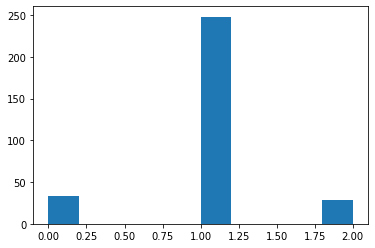

[1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 0 2 1 1 1
 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 0 0 0 1 1 1 1 1 2 2 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


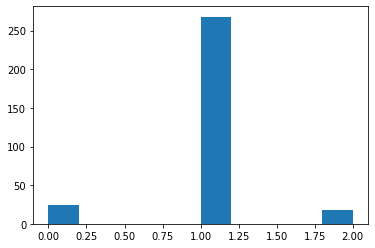

[1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 2 0 2 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 2 0 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 2 2 0 2 0 2 2 1 1 1
 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 0 2 2 1 1 1 1 1 2 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


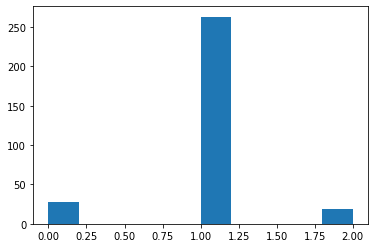

In [335]:
X_test_meta = np.zeros((new_test.shape[0], len(base_models)))
for i, model in enumerate(base_models):
    model.fit(final_X, y_class)

    y_test_pred = model.predict(new_test)
    print(y_test_pred)
    plt.hist(y_test_pred)
    plt.show()
    X_test_meta[:, i] = y_test_pred

y_pred = meta_model.predict(X_test_meta)

[1 1 1 0 0 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 2 0 2 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 0 1 1
 1 2 1 1 2 0 2 1 2 1 1 1 0 0 0 0 2 1 2 1 1 1 1 2 1 1 1 2 1 2 1 1 2 1 2 1 1
 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 0 2 2 2 1 1 1 1 2 2 1 1 0 0 1 2 2 1 2
 1 1 1 2 1 1 1 1 1 1 2 1 2 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1
 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 1 1 1
 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 0 2 2 1 1 1 1 1 2 1 1 1
 1 1 1 1 1 1 1 1 2 1 1 1 1 1]


(array([ 28.,   0.,   0.,   0.,   0., 234.,   0.,   0.,   0.,  48.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

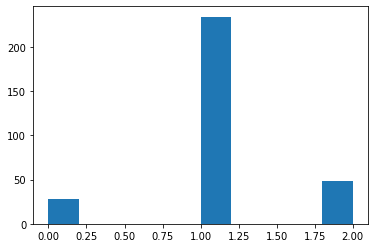

In [336]:
print(y_pred)
plt.hist(y_pred)

(array([ 88.,   0.,   0.,   0.,   0., 407.,   0.,   0.,   0., 103.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

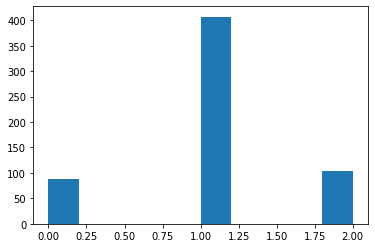

In [337]:
plt.hist(train_df['Y_Class'])

In [338]:
# # model1 = sorted_list[0][0]
# # model2 = sorted_list[1][0]
# # model3 = sorted_list[2][0]

# model1 = base_models[0]
# model1.fit(final_X, y_class)
# # model2.fit(final_X, y_class)
# # model3.fit(final_X, y_class)

# preds1 = model1.predict(new_test)
# # preds2 = model2.predict(new_test)
# # preds3 = model3.predict(new_test)

# print(preds1)
# # print(preds2)
# # print(preds3)


In [339]:
submit = pd.read_csv('/content/drive/MyDrive/LGAimers/sample_submission.csv')

In [340]:
# submit['Y_Class'] = preds1
# submit.to_csv('./submission_preds1.csv', index=False)
# submit['Y_Class'] = preds2 
# submit.to_csv('./submission_preds2.csv', index=False)
submit['Y_Class'] = y_pred
submit.to_csv('./submission_stacking.csv', index = False)